In [1]:
import os
import numpy as np
import mdtraj
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook
import mdtraj
import os
import glob

from ipywidgets import interact

In [2]:
def load_trajectories(coordinate_files, size_limit=None):
    coordinate_list = []
    label_list = []

    for cf in coordinate_files:
        batch_label = os.path.basename(cf)
        batch_traj = []
        for subtraj in glob.glob(cf):
            if subtraj.endswith("npy"):
                coords = np.load(subtraj, allow_pickle=True)
                if type(coords) == dict: # One of Raz's benchmark archives
                    batch_label = os.path.join(*(cf.split(os.path.sep)[-2:]))
                    batch_traj.extend(coords["mdtraj_list"])
                else: # A preprocess.py output file
                    batch_label = os.path.join(*(cf.split(os.path.sep)[-3:]))
                    # Convert to NM to match mdtraj coordinates
                    coords = coords/10
                    psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
                    traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
                    batch_traj.append(traj)
            else: # Something mdtraj can open
                traj = mdtraj.load(subtraj)
                batch_traj.append(traj)
        if len(batch_traj) == 0:
            raise RuntimeError(f"{cf} did not match any files")
        
        batch_traj = mdtraj.join(batch_traj)

        # Select with a stride that brings the total number of frames down to the size_limit
        if size_limit and len(batch_traj) > size_limit:
            batch_traj = batch_traj[::(len(batch_traj)//size_limit)]

        label_list.append(batch_label)
        coordinate_list.append(batch_traj)

    assert len(coordinate_list) == len(label_list)
    return coordinate_list, label_list


In [3]:
def calculate_angles(coordinates):
    # Calculate angles for a single carbon alpha chain (or some other simple linear series of bonds)
    # assert coordinates.n_chains == 1, "Only single chain proteins are supported"
    index_list = []
    for chain in coordinates.top.chains:
        a_idx = [i.index for i in chain.atoms]
        for i in range(len(a_idx) - 2):
            index_list.append(a_idx[i:i+3])
    return mdtraj.compute_angles(coordinates, index_list, periodic=False)

def calculate_dihedrals(coordinates):
    # Calculate angles for a single carbon alpha chain (or some other simple linear series of bonds)
    # assert coordinates.n_chains == 1, "Only single chain proteins are supported"
    index_list = []
    for chain in coordinates.top.chains:
        a_idx = [i.index for i in chain.atoms]
        for i in range(len(a_idx) - 3):
            index_list.append(a_idx[i:i+4])
    result = mdtraj.compute_dihedrals(coordinates, index_list, periodic=False)
    return result

calculate_density_with_kde = False

if calculate_density_with_kde:
    # The default matplotlib KDE method
    import matplotlib.mlab
    def violin_method(X, coords):
        # Unpack in case of e.g. Pandas or xarray object
        X = matplotlib.cbook._unpack_to_numpy(X)
        # fallback gracefully if the vector contains only one value
        if np.all(X[0] == X):
            return (X[0] == coords).astype(float)
        kde = matplotlib.mlab.GaussianKDE(X, 'scott')
        return kde.evaluate(coords)
else:
    def violin_method(X, coords):
        # The requested coords are the result of np.linspace(min_val, max_val, points)
        # To get histogram bind we add 1 more point in our linspace
        bin_edges = np.linspace(coords[0], coords[-1], len(coords)+1)
        hist = np.histogram(X, bin_edges, density=True)
        return hist[0]

**coordinate_files:** The first entry in this list should be the reference data, such as a model's training data or a benchmark dataset. Each entry after that is a simulation result to plot against the reference. Entries can be glob wildcards, e.g. `foo_*.h5`, and all matched trajectories will be concatenated together along the time dimension.

In [ ]:
coordinate_files = [
    "/media/DATA_18_TB_1/daniel_s/cgschnet/harmonic_net_2025.04.06/cg_high_density_benchmark_CA_only_2025.04.03_bba_s100_CA_lj_bondNull_angleNull_dihedralNull/bba*/raw/coordinates.npy",
    "/media/DATA_18_TB_1/daniel_s/cgschnet/harmonic_net_2025.04.06/reference_models/benchmarkE39_high_density_benchmark_CA_only_2025.04.03_mix1.1_s100_CA_Majewski2022_v1_cutoff2_seq6__wd0_plateaulr5en4_0.1_0_1en3_1en7_bs4_chunk120/bba_model_replicas.npy",
    "/media/DATA_18_TB_1/daniel_s/cgschnet/harmonic_net_2025.04.06/benchmarkE23_high_density_benchmark_CA_only_2025.04.03_bba_s100_CA_lj_bondNull_angleNull_dihedralNull_cutoff2_seq6_harBAD_termBAD100__wd0_plateaulr5en4_0.1_0_1en3_1en7_bs4/bba_model_replicas.npy",
]

coordinate_list, label_list = load_trajectories(coordinate_files, size_limit=50000)
for c, l in zip(coordinate_list, label_list):
    print(c, l)

assert all([coordinate_list[0].n_atoms == i.n_atoms for i in coordinate_list]), "All trajectories must have the same topology"

<mdtraj.Trajectory with 50000 frames, 28 atoms, 28 residues, without unitcells> bba*/raw/coordinates.npy
<mdtraj.Trajectory with 2000 frames, 28 atoms, 28 residues, and unitcells> benchmarkE39_high_density_benchmark_CA_only_2025.04.03_mix1.1_s100_CA_Majewski2022_v1_cutoff2_seq6__wd0_plateaulr5en4_0.1_0_1en3_1en7_bs4_chunk120/bba_model_replicas.npy
<mdtraj.Trajectory with 2000 frames, 28 atoms, 28 residues, and unitcells> benchmarkE23_high_density_benchmark_CA_only_2025.04.03_bba_s100_CA_lj_bondNull_angleNull_dihedralNull_cutoff2_seq6_harBAD_termBAD100__wd0_plateaulr5en4_0.1_0_1en3_1en7_bs4/bba_model_replicas.npy


In [5]:
angles_list = []
dihedrals_list = []

for c in coordinate_list:
    angles_list.append(calculate_angles(c))
    dihedrals_list.append(calculate_dihedrals(c))

angles_violin_stats_list = []
for a in angles_list:
    angles_violin_stats_list.append(matplotlib.cbook.violin_stats(a, method=violin_method, points=50))

dihedrals_violin_stats_list = []
for d in dihedrals_list:
    dihedrals_violin_stats_list.append(matplotlib.cbook.violin_stats(d, method=violin_method, points=50))

## Angle Distributions

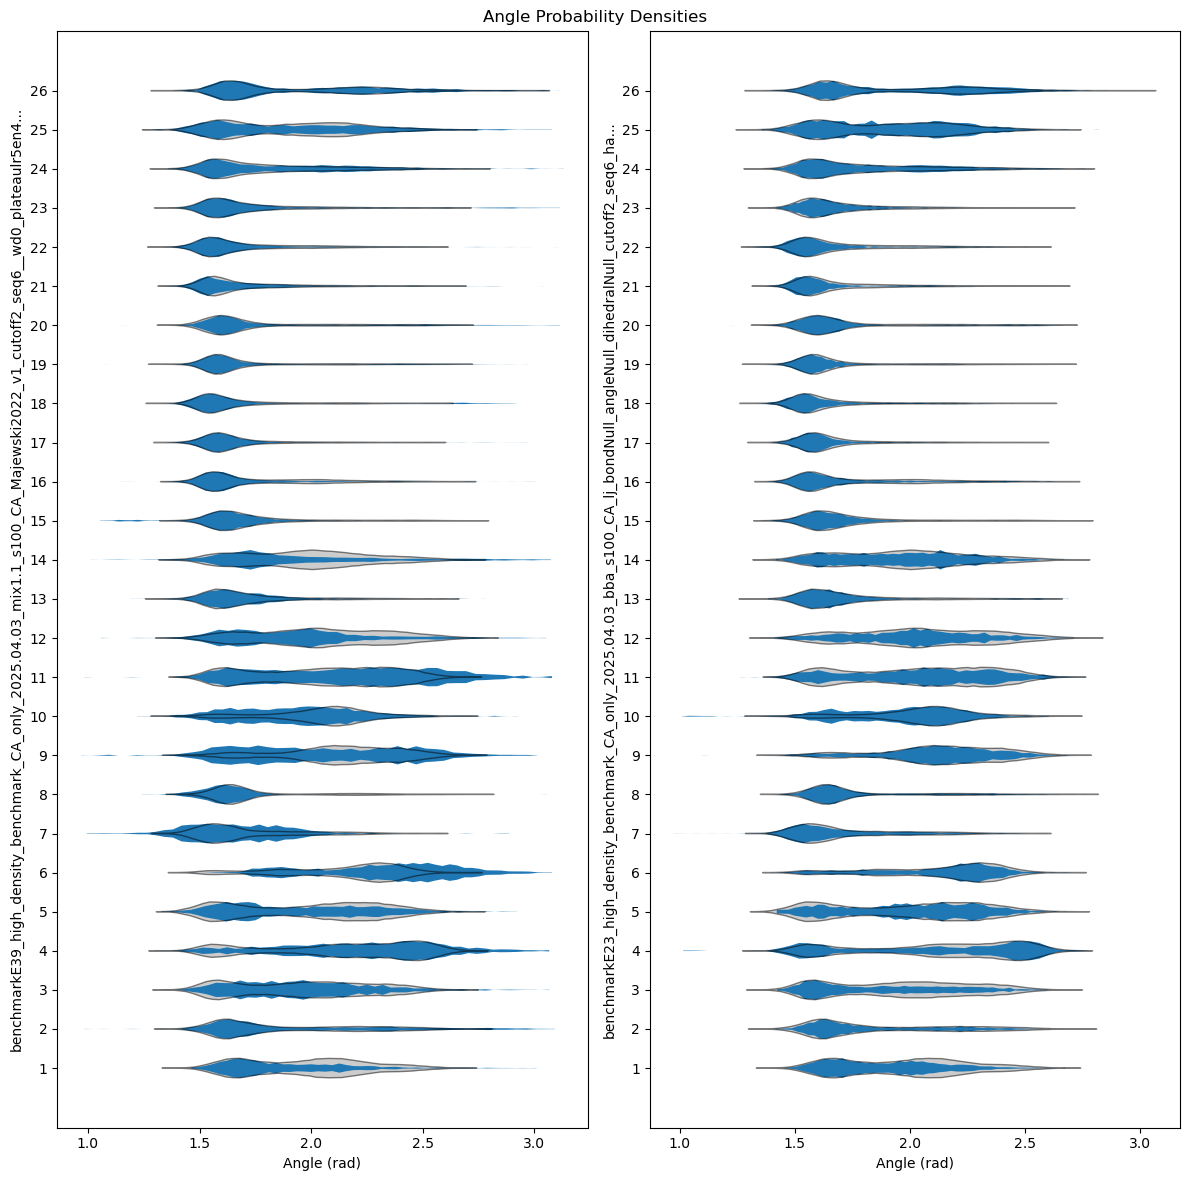

In [6]:
violin_stats = angles_violin_stats_list
num_violin = len(violin_stats) - 1

fig, axes = plt.subplots(1, num_violin, figsize=(6 * num_violin, 12))
if num_violin == 1:
    axes = [axes]

for i in range(num_violin):
    parts_bg = axes[i].violin(violin_stats[0], vert=False, showextrema=False)
    parts = axes[i].violin(violin_stats[i+1], vert=False, showextrema=False)
    parts_ref = axes[i].violin(violin_stats[0], vert=False, showextrema=False)

    axes[i].set_yticks(np.arange(len(violin_stats[0]))+1)

    for pc in parts_bg['bodies']:
        pc.set_facecolor('#CCCCCC')
        pc.set_edgecolor('none')
        pc.set_alpha(1)

    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b4')
        pc.set_edgecolor('none')
        pc.set_alpha(1)

    for pc in parts_ref['bodies']:
        pc.set_facecolor('none')
        pc.set_edgecolor('black')
        pc.set_alpha(.5)
        pc.set_linewidth(1)

    plot_label = label_list[i+1]
    if len(plot_label) > 120:
        plot_label = plot_label[:117] + "..."
    axes[i].set_ylabel(plot_label, fontsize=10)
    axes[i].set_xlabel("Angle (rad)")

fig.suptitle("Angle Probability Densities")
fig.tight_layout()

**Figure above:** A comparison of the ground truth vs. model's distribution of bond angles (the angle formed by 3 consecutive backbone (CA) beads). Black outlines and gray fill represent the ground truth distribution, blue fill is the observed distribution in the benchmark or simulation.

In [7]:
num_angles = len(angles_violin_stats_list[0])

def interactive_plot(angle_idx, dataset_idx):
    violin_stat_ref = angles_violin_stats_list[0][angle_idx-1]
    violin_stat = angles_violin_stats_list[dataset_idx][angle_idx-1]

    plt.plot(violin_stat_ref["coords"], violin_stat_ref["vals"], color='#606060', marker='o', markersize=3, linestyle='-', label="Reference")
    plt.fill_between(violin_stat_ref["coords"], violin_stat_ref["vals"], color='#CCCCCC')

    plt.plot(violin_stat["coords"], violin_stat["vals"], color='#1f77b4', label="Simulation", marker='o', markersize=3, linestyle='-')

    plt.legend()

    print(label_list[dataset_idx])
    print("Angle residues:", "-".join([coordinate_list[1].top.residue(i).name for i in range(angle_idx-2,angle_idx+1)]))

interact(interactive_plot, angle_idx=(1, num_angles), dataset_idx=(1, len(angles_list)-1))
pass

interactive(children=(IntSlider(value=13, description='angle_idx', max=26, min=1), IntSlider(value=1, descript…

## Dihedral Distributions

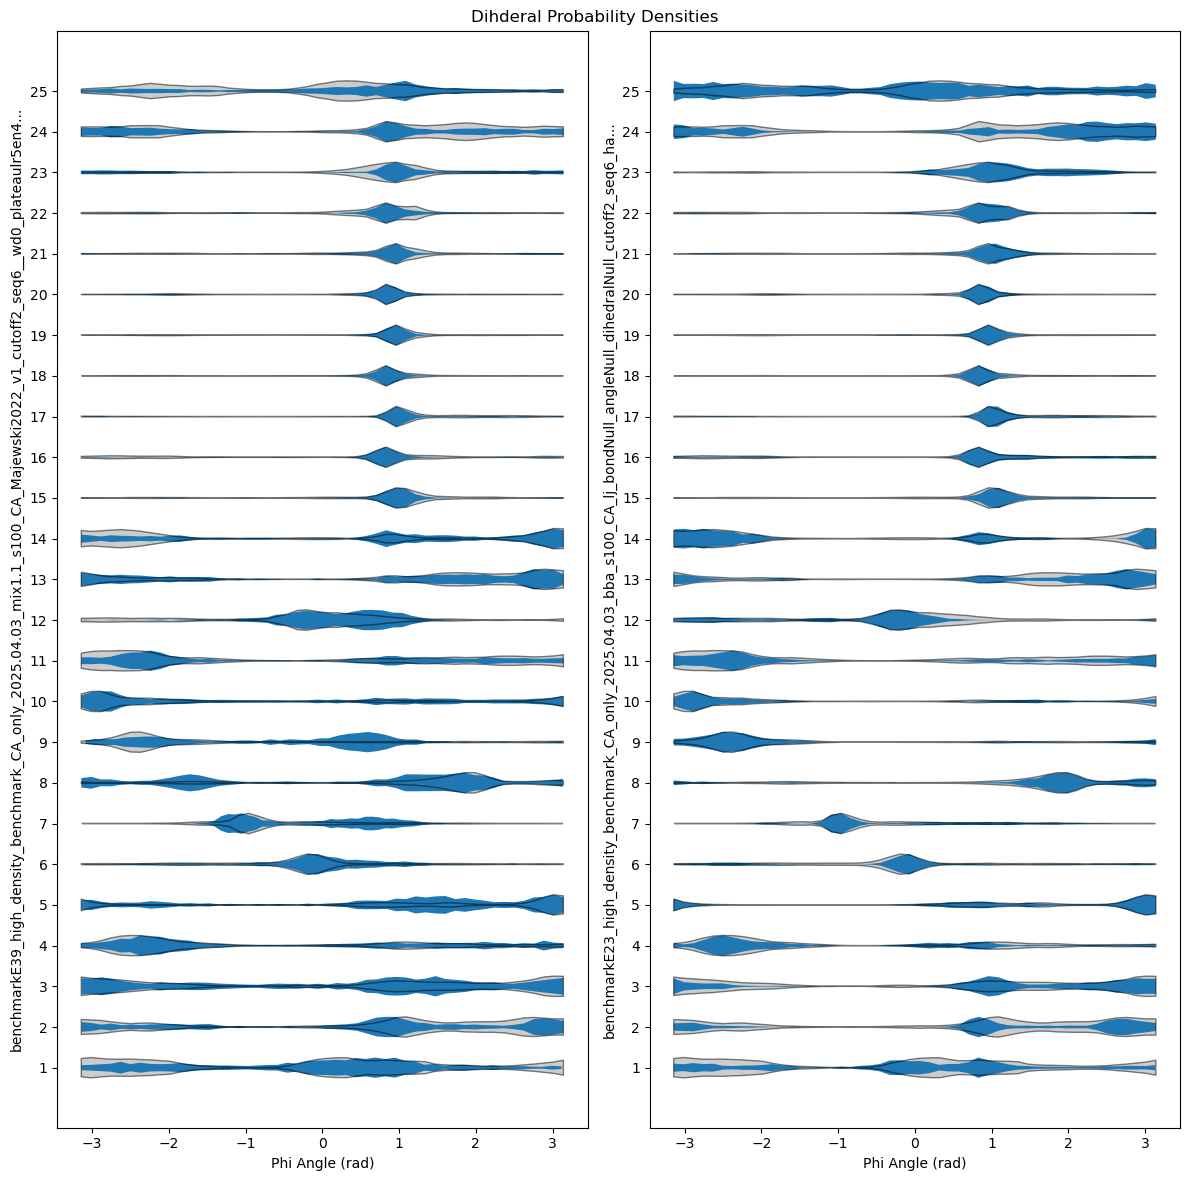

In [8]:
violin_stats = dihedrals_violin_stats_list
num_violin = len(violin_stats) - 1

fig, axes = plt.subplots(1, num_violin, figsize=(6 * num_violin, 12))
if num_violin == 1:
    axes = [axes]

for i in range(num_violin):
    parts_bg = axes[i].violin(violin_stats[0], vert=False, showextrema=False)
    parts = axes[i].violin(violin_stats[i+1], vert=False, showextrema=False)
    parts_ref = axes[i].violin(violin_stats[0], vert=False, showextrema=False)

    axes[i].set_yticks(np.arange(len(violin_stats[0]))+1)

    for pc in parts_bg['bodies']:
        pc.set_facecolor('#CCCCCC')
        pc.set_edgecolor('none')
        pc.set_alpha(1)

    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b4')
        pc.set_edgecolor('none')
        pc.set_alpha(1)

    for pc in parts_ref['bodies']:
        pc.set_facecolor('none')
        pc.set_edgecolor('black')
        pc.set_alpha(.5)
        pc.set_linewidth(1)


    plot_label = label_list[i+1]
    if len(plot_label) > 120:
        plot_label = plot_label[:117] + "..."
    axes[i].set_ylabel(plot_label, fontsize=10)
    axes[i].set_xlabel("Phi Angle (rad)")

fig.suptitle("Dihderal Probability Densities")
fig.tight_layout()

**Figure above:** A comparison of the ground truth vs. model's distribution of dihedral angles (for 4 sequential beads A-B-C-D a diehedral is angle between the planes A-B-C and B-C-D). Black outlines and gray fill represent the ground truth distribution, blue fill is the observed distribution in the benchmark or simulation.

In [9]:
num_dihedrals = len(dihedrals_violin_stats_list[0])

def interactive_plot(dihedral_idx, dataset_idx):
    violin_stat_ref = dihedrals_violin_stats_list[0][dihedral_idx-1]
    violin_stat = dihedrals_violin_stats_list[dataset_idx][dihedral_idx-1]

    plt.plot(violin_stat_ref["coords"], violin_stat_ref["vals"], color='#606060', marker='o', markersize=3, linestyle='-', label="Reference")
    plt.fill_between(violin_stat_ref["coords"], violin_stat_ref["vals"], color='#CCCCCC')

    plt.plot(violin_stat["coords"], violin_stat["vals"], color='#1f77b4', label="Simulation", marker='o', markersize=3, linestyle='-')

    plt.legend()

    print(label_list[dataset_idx])
    print("dihedral residues:", "-".join([coordinate_list[1].top.residue(i).name for i in range(dihedral_idx-2,dihedral_idx+1)]))


interact(interactive_plot, dihedral_idx=(1, num_dihedrals+1), dataset_idx=(1, len(dihedrals_list)-1))
pass

interactive(children=(IntSlider(value=13, description='dihedral_idx', max=26, min=1), IntSlider(value=1, descr…